## RNN

In [28]:
# 사용할 상수 정의 

VOCAB_SIZE = 300  # 어휘 사전의 크기(사용할 단어 수)
SEQ_LENGTH = 150  # 시퀀스 하나의 최대 길이

### 데이터 준비

In [29]:
from tensorflow.keras.datasets import imdb 

# imdb : 인터넷 영화 데이터베이스
# 각 데이터는 (리뷰 내용, 리뷰 레이블)로 구성
# 긍정/부정 리뷰 데이터셋 제공
# 레이블 : 0(부정), 1(긍정)
# 훈련 데이터 25,000개, 테스트 데이터 25,000개로 구성
# 데이터는 이미 정수 인코딩(단어를 정수로 변환)되어 있음
# 데이터셋은 keras.datasets.imdb 모듈에서 제공
# 튜플의 형태로 (훈련 데이터, 테스트 데이터) 제공

# load_data() : imdb 데이터셋을 불러오는 함수
#     - num_words : 자주 등장하는 단어 순서대로 몇 개의 단어를 사용할지 지정
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE) 
 


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 시퀀스 길이 맞추기 => 왜? RNN 모델에 입력하려면 시퀀스 길이가 같아야 하기 때문
train_seq = pad_sequences(train_input, maxlen=SEQ_LENGTH)
test_seq = pad_sequences(test_input, maxlen=SEQ_LENGTH)

train_seq.shape, test_seq.shape

((25000, 150), (25000, 150))

In [31]:
# Torch Tensor 변환
import torch

# 시퀀스 데이터를 LongTensor로 변환 (정수형 텐서)
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000]

# 레이블 데이터를 FloatTensor로 변환 (실수형 텐서)
train_target = torch.tensor(train_target[:10000], dtype=torch.float)
test_target = torch.tensor(test_target[:5000], dtype=torch.float)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

10000 5000
torch.Size([10000]) torch.Size([5000])


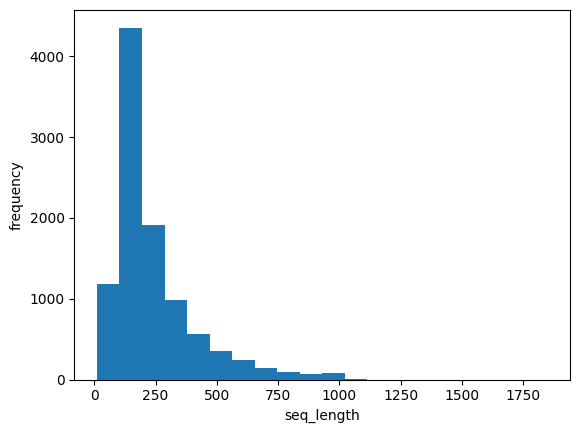

In [32]:
import matplotlib.pyplot as plt

train_len = [len(seq) for seq in train_input]
plt.hist(train_len, bins=20)
plt.xlabel("seq_length")
plt.ylabel("frequency")
plt.show()

In [34]:
import torch.nn.functional as F # 패딩 함수 사용을 위해 임포트

# 시퀀스 길이 맞추기 함수 정의
def pad_sequences(sequences, maxlen, padding_value=0):
    # 0으로 패딩 추가 (또는 자르기) 
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen - len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LENGTH)
test_seq = pad_sequences(test_input, maxlen=SEQ_LENGTH)

In [ ]:
# one-hot encoding

# 시퀀스 데이터를 원-핫 인코딩으로 변환
# 각 단어를 VOCAB_SIZE 크기의 벡터로 변환
# 예: 단어 인덱스 5 -> [0, 0, 0, 0, 0, 1, 0, ..., 0] (VOCAB_SIZE 길이)
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

### 모델 준비 및 학습

In [38]:
import torch.nn as nn

# RNN 모델 정의
class SentimentRNN(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__() # 부모 클래스 nn.Module 초기화
        
        # RNN 레이어 정의
        self.rnn = nn.RNN(
            input_size=vocab_size, # 입력 크기 (원-핫 인코딩 벡터 크기) 
            hidden_size=hidden_dim, # 은닉 상태 크기
            batch_first=True # 입력 텐서의 첫 번째 차원이 배치 크기임을 지정
            )
        
        # 출력 레이어 정의
        self.fx = nn.Linear(
            hidden_dim, # 입력 크기 (RNN의 은닉 상태 크기)
            output_dim # 출력 크기 (긍정/부정 분류)
            )
        self.sigmoid = nn.Sigmoid() # 시그모이드 활성화 함수 정의
        
    def forward(self, x): # 순전파 메서드 정의 
        _, hidden = self.rnn(x)  # RNN 레이어 통과
        out = self.fx(hidden.squeeze(0)) # 출력 레이어 통과
        return self.sigmoid(out) # 시그모이드 활성화 함수 적용 후 반환

In [ ]:
HIDDEN_DIM = 8  # RNN 은닉 상태 크기
OUTPUT_DIM = 1  # 출력 크기 (긍정/부정 분류)

model = SentimentRNN(
    seq_len=SEQ_LENGTH, # 시퀀스 길이
    vocab_size=VOCAB_SIZE, # 어휘 사전 크기
    hidden_dim=HIDDEN_DIM, # 은닉 상태 크기
    output_dim=OUTPUT_DIM # 출력 크기
)

print(model)

SentimentRNN(
  (rnn): RNN(300, 8, batch_first=True)
  (fx): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [40]:
# 학습을 위한 설정
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

BATCH_SIZE = 64  # 배치 크기

train_size = int(0.8 * len(train_onehot))  # 훈련 데이터 크기 (80%)
val_size = len(train_onehot) - train_size  # 검증 데이터 크기 (20%)

# label을 float 타입으로 변환
train_target = train_target.float()
test_target = test_target.float()

# 훈련 데이터와 검증 데이터를 분할
# TensorDataset : 텐서 데이터를 묶어서 데이터셋으로 만듦
train_dataset, val_dataset = random_split(
    TensorDataset(train_onehot, train_target),  # 전체 훈련 데이터셋
    [train_size, val_size] # 분할할 크기 리스트 (훈련 데이터 크기, 검증 데이터 크기)
    )

# DataLoader : 배치 단위로 데이터를 불러오는 역할
train_loader = DataLoader(
    train_dataset, # 훈련 데이터셋
    batch_size=BATCH_SIZE, # 배치 크기
    shuffle=True # 데이터 섞기
)
val_loader = DataLoader( # 검증 데이터 로더
    val_dataset, # 검증 데이터셋
    batch_size=BATCH_SIZE,  # 배치 크기
)

epochs = 100  # 에포크 수
criterion = nn.BCELoss()  # 이진 교차 엔트로피 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Adam 옵티마이저

train_losses, val_losses, train_accs, val_accs = [], [], [], []  # 훈련 손실 및 정확도 기록용 리스트

early_stopping_patience = 5  # 조기 종료를 위한 인내심 설정
best_val_loss = float('inf')  # 최상의 검증 손실 초기화
early_stop_counter = 0  # 인내심 카운터 초기화


In [41]:
# 학습 과정
for epoch in range(epochs):
    model.train()  # 모델을 훈련 모드로 설정
    total_loss, total, correct = 0, 0, 0  # 총 손실 및 정확도 초기화
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(inputs).squeeze()  # 모델에 입력 데이터 전달하여 출력 계산 
        
        loss = criterion(outputs, targets)  # 손실 계산
        
        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트
        
        total_loss += loss.item()
        
        predicted = (outputs >= 0.5).float()  # 예측값 이진화
        correct += (predicted == targets).sum().item()  # 정확한 예측 수 누적
        total += targets.size(0)  # 전체 샘플 수 누적

    
    train_loss = total_loss / len(train_loader)  # 평균 훈련 손실 계산
    train_acc = correct / total  # 훈련 정확도 계산
    train_losses.append(train_loss)  # 훈련 손실 기록
    train_accs.append(train_acc)  # 훈련 정확도 기록
    
    
    # 검증 모드
    model.eval()  # 모델을 평가 모드로 설정 
    val_loss, val_total, val_correct = 0, 0, 0  # 총 손실 및 정확도 초기화

    with torch.no_grad():  # 기울기 계산 비활성화
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs).squeeze()  # 모델에 입력 데이터 전달하여 출력 계산

            loss = criterion(val_outputs, val_targets)  # 손실 계산 
            total_loss += loss.item()

            predicted = (val_outputs >= 0.5).float()  # 예측값 이진화
            val_correct += (predicted == val_targets).sum().item()  # 정확한 예측 수 누적
            val_total += val_targets.size(0)  # 전체 샘플 수 누적


    val_loss = total_loss / len(val_loader)  # 평균 검증 손실 계산
    val_acc = val_correct / val_total  # 검증 정확도 계산
    val_losses.append(val_loss)  # 검증 손실 기록
    val_accs.append(val_acc)  # 검증 정확도 기록
    
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 조기종료 처리
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping!!!")
            break


Epoch 1/100 | Train Loss: 0.6944, Train Acc: 0.5118, Val Loss: 3.4077, Val Acc: 0.5060
Epoch 2/100 | Train Loss: 0.6892, Train Acc: 0.5327, Val Loss: 3.3926, Val Acc: 0.4700
Epoch 3/100 | Train Loss: 0.6822, Train Acc: 0.5466, Val Loss: 3.3718, Val Acc: 0.4925
Epoch 4/100 | Train Loss: 0.6694, Train Acc: 0.5705, Val Loss: 3.3365, Val Acc: 0.4615
Epoch 5/100 | Train Loss: 0.6543, Train Acc: 0.5855, Val Loss: 3.2961, Val Acc: 0.4980
Epoch 6/100 | Train Loss: 0.6430, Train Acc: 0.5941, Val Loss: 3.2652, Val Acc: 0.4950
Epoch 7/100 | Train Loss: 0.6332, Train Acc: 0.6130, Val Loss: 3.2353, Val Acc: 0.4665
Epoch 8/100 | Train Loss: 0.6251, Train Acc: 0.6155, Val Loss: 3.2276, Val Acc: 0.5000
Epoch 9/100 | Train Loss: 0.6192, Train Acc: 0.6248, Val Loss: 3.2112, Val Acc: 0.4625
Epoch 10/100 | Train Loss: 0.6129, Train Acc: 0.6315, Val Loss: 3.2039, Val Acc: 0.5045
Epoch 11/100 | Train Loss: 0.6073, Train Acc: 0.6419, Val Loss: 3.1853, Val Acc: 0.5105
Epoch 12/100 | Train Loss: 0.6013, Train 

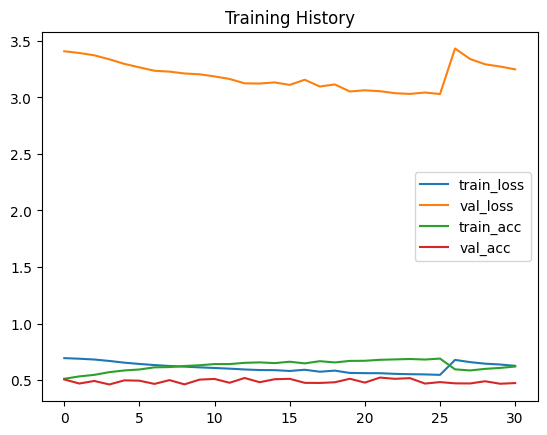

In [ ]:
train_history_df = pd.DataFrame({
    'train_loss': train_losses, # 훈련 손실 기록
    'val_loss': val_losses, # 검증 손실 기록
    'train_acc': train_accs, #  훈련 정확도 기록
    'val_acc': val_accs  # 검증 정확도 기록
})

train_history_df.plot(title="Training History")
plt.show()

In [43]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정 
    val_loss, val_total, val_correct = 0, 0, 0  # 총 손실 및 정확도 초기화

    with torch.no_grad():  # 기울기 계산 비활성화
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs).squeeze()  # 모델에 입력 데이터 전달하여 출력 계산

            loss = criterion(val_outputs, val_targets)  # 손실 계산 
            val_loss += loss.item()

            predicted = (val_outputs >= 0.5).float()  # 예측값 이진화
            val_correct += (predicted == val_targets).sum().item()  # 정확한 예측 수 누적
            val_total += val_targets.size(0)  # 전체 샘플 수 누적


    test_loss = val_loss / len(test_loader)  # 평균 검증 손실 계산
    test_acc = val_correct / val_total  # 검증 정확도 계산 
    return test_loss, test_acc

In [44]:
test_dataset = TensorDataset(test_onehot, test_target)  # 테스트 데이터셋 생성
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)  # 테스트 데이터 로더 생성

test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.7679, Test Acc: 0.5004
